In [1]:
from sage.misc.prandom import randrange
from sage.misc.randstate import current_randstate

import time
import csv

def kvadrat(m,n,vel): # m proizvajalcev, n porabnikov
    s = ([[(RR.random_element(-vel,vel),RR.random_element(-vel,vel)),ZZ.random_element(1,10)] for i in range(m)])
    d = ([[(RR.random_element(-vel,vel),RR.random_element(-vel,vel)),ZZ.random_element(1,10)] for j in range(n)])
    vsota_proizvodnje = sum(k for xy, k in s)
    for i in range(len(s)):
        s[i][1] = s[i][1] * (1/vsota_proizvodnje)
    vsota_porabe = sum(k for xy, k in d)
    for j in range(len(d)):
        d[j][1] = d[j][1] * (1/vsota_porabe)
    return s,d

def krog(m,n,radij_kroga):
    s = []
    d = []
    while len(s) < m:
        x = RR.random_element(-radij_kroga,radij_kroga)
        y = RR.random_element(-radij_kroga,radij_kroga)
        razdalja = sqrt(x^2+y^2)
        if razdalja <= radij_kroga:
            s.append([(x,y),ZZ.random_element(1,10)])
        else:
            continue
    while len(d) < n:
        x = RR.random_element(-radij_kroga,radij_kroga)
        y = RR.random_element(-radij_kroga,radij_kroga)
        razdalja = sqrt(x^2+y^2)
        if razdalja <= radij_kroga:
            d.append([(x,y),ZZ.random_element(1,10)])
        else:
            continue
    vsota_proizvodnje = sum(k for xy, k in s)
    for i in range(len(s)):
        s[i][1] = s[i][1] * (1/vsota_proizvodnje)
    vsota_porabe = sum(k for xy, k in d)
    for j in range(len(d)):
        d[j][1] = d[j][1] * (1/vsota_porabe)
    return s,d

def strani(m,n,vel):
    s = ([[(-5,RR.random_element(-vel,vel)),ZZ.random_element(1,10)] for i in range(m)])
    d = ([[(5,RR.random_element(-vel,vel)),ZZ.random_element(1,10)] for j in range(n)])
    vsota_proizvodnje = sum(k for xy, k in s)
    for i in range(len(s)):
        s[i][1] = s[i][1] * (1/vsota_proizvodnje)
    vsota_porabe = sum(k for xy, k in d)
    for j in range(len(d)):
        d[j][1] = d[j][1] * (1/vsota_porabe)
    return s,d

def program(s,d):
    m = len(s)
    n = len(d)
    p = MixedIntegerLinearProgram(maximization=False)
    b = p.new_variable(binary=True)
    c = p.new_variable(nonnegative=True)
    p.set_objective(p['l'])
    p.add_constraint((p['l']) >= 0)
    for i, ((sx, sy), sk) in enumerate(s):
        for j, ((dx, dy), dk) in enumerate(d):
            p.add_constraint(b[i, j] * sqrt((dx-sx)^2 + (dy-sy)^2) <= p['l'])
            p.add_constraint(c[i, j] >= 0)
            p.add_constraint(c[i, j] <= sk * b[i, j])
    for i, (sxy, sk) in enumerate(s):
        p.add_constraint(p.sum(c[i, j] for j in range(n)) == sk)
    for j, (dxy, dk) in enumerate(d):
        p.add_constraint(p.sum(c[i, j] for i in range(m)) == dk)
    z = p.solve()
    povezave = p.get_values(b)
    kolicine = p.get_values(c)
    return z, povezave, kolicine

def simulacija(stevilo_ponovitev,vrsta_podatkov,red):
    razdalje = []
    sys.stdout.flush()
    if vrsta_podatkov == 'kvadrat':
        start = time.time()
        for i in range(stevilo_ponovitev):
            stevilo_proizvajalcev = ZZ.random_element(1,10)
            stevilo_porabnikov = ZZ.random_element(1,10)
            s,d = kvadrat(stevilo_proizvajalcev,stevilo_porabnikov,red)
            z, povezave, kolicine = program(s,d)
            razdalje.append([z])
        end = time.time()
        cas = end-start
        print("velikost-> %d, cas = %.2f" % (red, cas))
        return razdalje
    elif vrsta_podatkov == 'krog':
        start = time.time()
        for i in range(stevilo_ponovitev):
            stevilo_proizvajalcev = ZZ.random_element(1,10)
            stevilo_porabnikov = ZZ.random_element(1,10)
            s,d = krog(stevilo_proizvajalcev,stevilo_porabnikov,red)
            z, povezave, kolicine = program(s,d)
            razdalje.append([z])
        end = time.time()
        cas = end-start
        print("velikost-> %d, cas = %.2f" % (red, cas))
        return razdalje
    elif vrsta_podatkov == 'strani':
        start = time.time()
        for i in range(stevilo_ponovitev):
            stevilo_proizvajalcev = ZZ.random_element(1,10)
            stevilo_porabnikov = ZZ.random_element(1,10)
            s,d = strani(stevilo_proizvajalcev,stevilo_porabnikov,red)
            z, povezave, kolicine = program(s,d)
            razdalje.append([z])
        end = time.time()
        cas = end-start
        print("velikost-> %d, cas = %.2f" % (red, cas))
        return razdalje
    else:
        return []

def casovna_zahtevnost(zacetek,konec, korak, velikost):
    sys.stdout.flush()
    seznam = []
    for i in range(zacetek,konec,korak):
        start = time.time()
        s, d = kvadrat(i,i,velikost)
        z, povezave, kolicine = program(s,d)
        end = time.time()
        cas = end-start
        seznam.append([i,cas])
    return seznam

class Vozlisce:
    """Objekti, ki predstavljajo vozlišča."""

    def __init__(self, xy, k):
        """Hranimo pozicijo in količino."""
        self.xy = xy
        self.k = k

    def __str__(self):
        """Na vozlišču naj se izpiše količina."""
        return str(self.k) # izpisalo se bo kot ulomek

class Razvoz(DiGraph):
    """Usmerjen graf, ki predstavlja razvoz."""

    def __init__(self, s, d, povezave, kolicine):
        """"Podamo seznama proizvajalcev in porabnikov ter slovarja povezav in količin."""
        ss = [Vozlisce(*xyk) for xyk in s] # seznam vozlišč za proizvajalce
        dd = [Vozlisce(*xyk) for xyk in d] # seznam vozlišč za porabnike
        # inicializacija grafa s povezavami - oznake sestojijo iz prepeljanih količin in razdalje med vozliščema
        super().__init__([(ss[i], dd[j], '%.2f\n%.2f' % (kolicine[i, j], sqrt(sum((sw-dw)^2 for sw, dw in
                                                                                  zip(s[i][0], d[j][0])))))
                          for (i, j), v in povezave.items() if v])
        self.set_pos({u: u.xy for u in self}) # nastavimo pozicije vozlišč pri izrisovanju
        self.barve = {"lightblue": ss, "lightgreen": dd} # nastavimo privzete barve vozliščem

    def graphplot(self, **options):
        """Metoda za izrisovanje grafa z nastavitvijo privzetih vrednosti."""
        options.setdefault('edge_labels', True) # na povezavah naj se izpišejo količine
        options.setdefault('vertex_colors', self.barve) # uporabimo privzete barve vozlišč
        options.setdefault('vertex_size', 500)
        options.setdefault('figsize', [8, 6])
        # options.setdefault('edge_thickness',0.1)
        # options.setdefault('edge_labels_background', 'transparent')
        return super().graphplot(**options)


In [2]:
def zapis_podatkov(stevilo_ponovitev,vrsta_podatkov,red,ime):
    C = simulacija(stevilo_ponovitev,vrsta_podatkov,red)
    with open(ime, 'w') as f:
        c = csv.writer(f)
        c.writerows(C)

In [3]:
zapis_podatkov(100, 'kvadrat',10,'100_ponovitev_kvadrat_dolžina_20')

velikost-> 10, cas = 1.52


In [4]:
zapis_podatkov(100,'krog',5,'100_ponovitev_krog_polmer_5')

velikost-> 5, cas = 3.29


In [5]:
zapis_podatkov(100,'strani',10,'100_ponovitev_strani_dolžina_20')

velikost-> 10, cas = 2.51


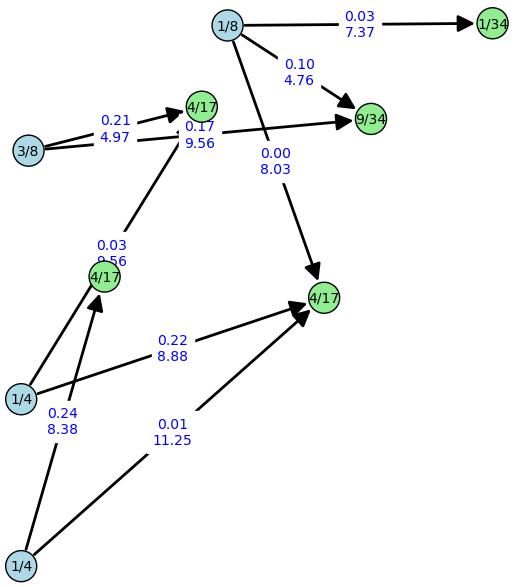

In [6]:
with seed(1):
    k_1, l_1 = kvadrat(4,5,10)
z_1, povezave_1, kolicine_1 = program(k_1, l_1)
Razvoz(k_1, l_1, povezave_1, kolicine_1).plot(fontsize = 6)

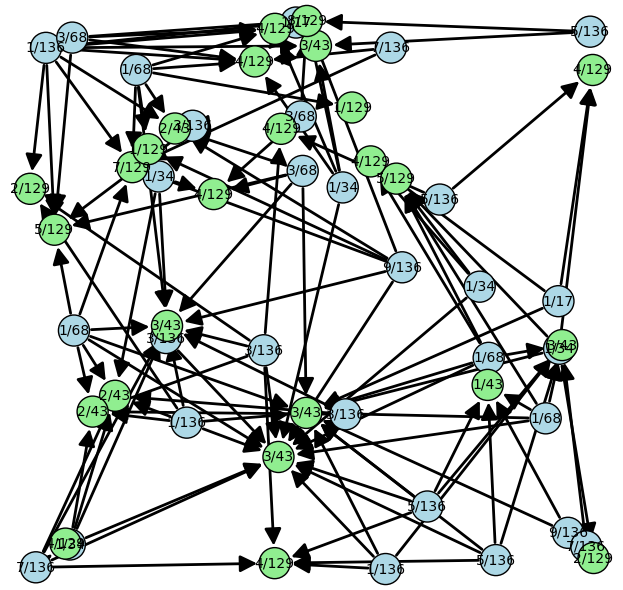

In [7]:
with seed(2):
    k_2, l_2 = kvadrat(30,25,20)
z_2, povezave_2, kolicine_2 = program(k_2, l_2)
Razvoz(k_2, l_2, povezave_2, kolicine_2).plot(edge_labels=False)

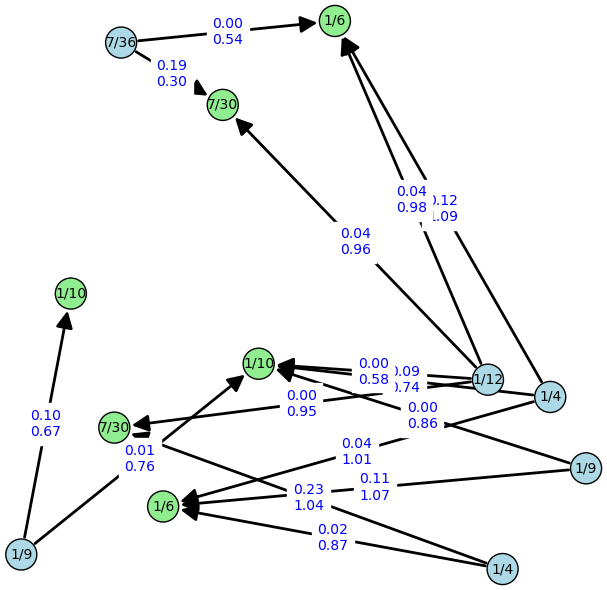

In [8]:
with seed(3):
    u_3, v_3 = krog(6,6,1)
l_3, povezave_3, kolicine_3 = program(u_3, v_3)
Razvoz(u_3, v_3, povezave_3, kolicine_3).plot(fontsize = 6)

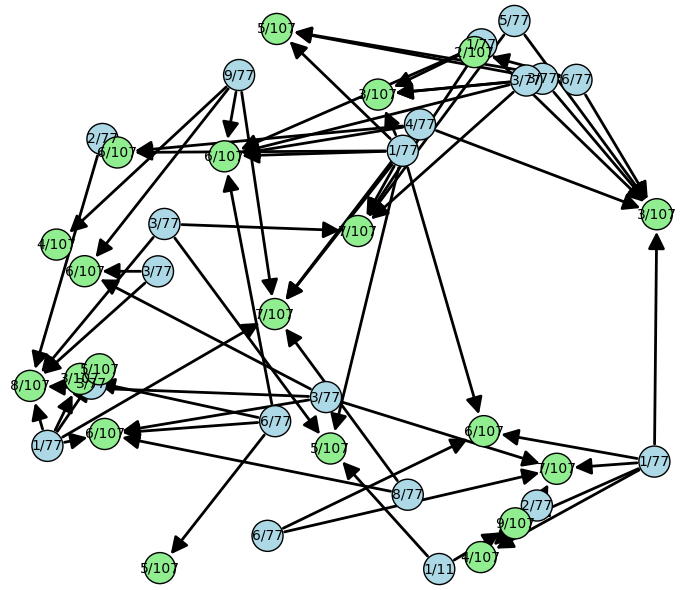

In [9]:
with seed(4):
    u_4, v_4 = krog(20,20,3)
l_4, povezave_4, kolicine_4 = program(u_4, v_4)
Razvoz(u_4, v_4, povezave_4, kolicine_4).plot(edge_labels = False)

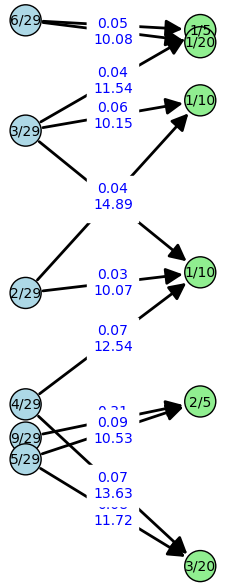

In [10]:
with seed(5):
    j_5, m_5 = strani(6,6,20)
o_5, povezave_5, kolicine_5 = program(j_5, m_5)
Razvoz(j_5, m_5, povezave_5, kolicine_5).plot()

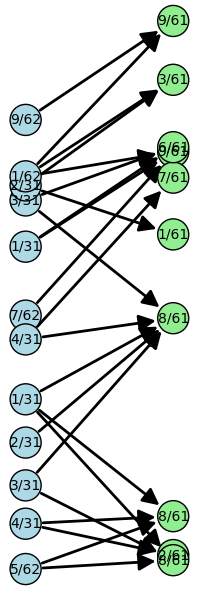

In [11]:
with seed(6):
    a_6, b_6 = strani(12,10,20)
c_6, povezave_6, kolicine_6 = program(a_6, b_6)
Razvoz(a_6, b_6, povezave_6, kolicine_6).plot(edge_labels = False)

In [12]:
casovna_zahtevnost(1,10,1,5)

[[1, 0.0008573532104492188],
 [2, 0.0014967918395996094],
 [3, 0.0024580955505371094],
 [4, 0.004334211349487305],
 [5, 0.005921840667724609],
 [6, 0.04099678993225098],
 [7, 0.026164770126342773],
 [8, 0.06644535064697266],
 [9, 0.028110504150390625]]

In [13]:
casovna_zahtevnost(1,15,2,5)

[[1, 0.0006573200225830078],
 [3, 0.0017366409301757812],
 [5, 0.005577564239501953],
 [7, 0.012008905410766602],
 [9, 0.03377795219421387],
 [11, 0.4254615306854248],
 [13, 0.9655511379241943]]

In [15]:
casovna_zahtevnost(1,20,5,5)

[[1, 0.0009431838989257812],
 [6, 0.013744831085205078],
 [11, 0.22989344596862793],
 [16, 0.6231584548950195]]

In [16]:
casovna_zahtevnost(1,30,10,5)

[[1, 0.0006539821624755859],
 [11, 0.3939692974090576],
 [21, 2.7057607173919678]]

In [17]:
casovna_zahtevnost(1,10,2,5)

[[1, 0.0007278919219970703],
 [3, 0.0019121170043945312],
 [5, 0.0072062015533447266],
 [7, 0.012198686599731445],
 [9, 0.5466301441192627]]

In [19]:
casovna_zahtevnost(1,40,20,5)

[[1, 0.0006856918334960938], [21, 2.036264181137085]]

In [20]:
casovna_zahtevnost(1,15,5,5)

[[1, 0.0008356571197509766],
 [6, 0.09595441818237305],
 [11, 0.5176160335540771]]

In [23]:
casovna_zahtevnost(1,15,2,5)

[[1, 0.0007781982421875],
 [3, 0.0027174949645996094],
 [5, 0.006720066070556641],
 [7, 0.01538848876953125],
 [9, 3.106132984161377],
 [11, 0.12839412689208984],
 [13, 0.9827239513397217]]

In [24]:
q,u = kvadrat(15,15,10)
z,p,k = program(q,u)
z

11.446627530336587